In [1]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
import edward_tools.fq_runner as fq_runner
from edward_tools.visualization import animate_sim_flux_qubit
from PARAMETER_INPUT import *
from PARAMETER_INPUT import _lambda, _theta, _eta
from edward_tools.initial_state_sampling import extra_constraint_00_and_11_only
import kyle_tools as kt
import matplotlib.pyplot as plt

import importlib, os, datetime
from edward_tools import coupled_fq_protocol_library, cfq_runner
from edward_tools import coupled_fq_protocol_library
import edward_tools.cfq_batch_sweep as cfq_batch_sweep

coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
get_potential_shot_at_different_t_1D = coupled_fq_protocol_library.get_potential_shot_at_different_t_1D
create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
coupled_fq_runner = importlib.reload(cfq_runner)
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system


In [2]:
# 4. Szilard engine test

In [3]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
params = {}
params['N'] = 5_000
params['dt'] = 1/1_000
params['lambda'] = 1
params['beta'] = 1
params['sim_params'] = [_lambda, _theta, _eta]
params['target_work'] = None
params['comment'] = "new protocol with varying dt"



In [4]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_c]
[phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound] = np.array([4, 4, 4, 4])/time_scale_factor

coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_1dc_bound, -phi_2dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound]]

coupled_fq_pot = Potential(coupled_flux_qubit_pot, coupled_flux_qubit_force, 14, 4,\
                           default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

In [5]:
"""
# step 2: Define initial condition and protocol
"""
manual_domain=[np.array([-5, -5]), np.array([5, 5])]
# phi_1_dcx, phi_2_dcx = 3, 3
phi_1_dcx, phi_2_dcx = 0, 0
phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx

phi_1_dcx_off = 0
phi_2_dcx_off = 0
M_12_off = 0

# bookmark
phi_1_dcx_on = 3.0
phi_2_dcx_on = 3.0
M_12_on = -0.6

initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": gamma,  "gamma_2": gamma,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1 ,   "d_beta_2": d_beta_2,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_1_dcx_off,
        "M_12": M_12_off, 'x_c': x_c
}



In [26]:
zeroDissipation = False
params['sim_params'] = [_lambda, _theta, _eta]
if zeroDissipation:
    params['sim_params'] = [_lambda * 0, _theta, _eta * 0]



"""
1 <-> -1     (0, 0, 0), (0, 3, 0), (0, 0, 0)
2 <-> -2     (0, 3, 0), (0, 3, -0.05), (0, 3, 0)
3 <-> -3     (0, 3, -0.05), (0, 0, -0.05), (0, 3, -0.05)
4 <-> -4     (0, 0, -0.05), (0, 0, 0), (0, 0, -0.05)
5 <-> -5     (0, 0, 0), (3, 0, 0), (0, 0, 0)
6 <-> -6     (3, 0, 0), (0, 0, 0), (3, 0, 0)
"""
TR_initial_condition = [
    (phi_1_dcx_off, phi_2_dcx_off, M_12_off), 
    (phi_1_dcx_off, phi_2_dcx_on,  M_12_off), 
    (phi_1_dcx_off, phi_2_dcx_on,  M_12_on), 
    (phi_1_dcx_off, phi_2_dcx_off, M_12_on), 
    (phi_1_dcx_off, phi_2_dcx_off, M_12_off), 
    (phi_1_dcx_on,  phi_2_dcx_off, M_12_off)]

protocol_index = 0

# initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"] = TR_initial_condition[protocol_index-1]
initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"],\
initial_parameter_dict["M_12"] = TR_initial_condition[0]

rest = lambda t: {"duration": t, "name":"rest"}
duration_t = 40
protocol_list = [
    # forward
    {"duration":duration_t, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(1) mix in y direction"},
    {"duration":duration_t, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_on,   "name":"(2) conditional tilt"},
    {"duration":duration_t, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(3) raise the barrier"},
    {"duration":duration_t, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,  "name": "(4) conditional tilt in x"}, 
    {"duration":duration_t, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(5) mix in x direction"}, 
    {"duration":duration_t, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(6) 4 well potential"}, 
    
]

# protocol_list = [
#     {"duration": 40, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(1) mix in y direction"},
#     {"duration": 120, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_on,   "name":"(2) conditional tilt"},
#     {"duration": 40, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(3) raise the barrier"},
#     {"duration": 40, "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(4) 4 well potential 1st time"}, 
#     {"duration": 40, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(5) mix in x direction"}, 
#     {"duration": 40, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(6) 4 well potential"}, 
# ]


protocol_time_array = [item["duration"] for item in protocol_list]
protocol_time_array.insert(0, 0)
protocol_time_array = np.cumsum(protocol_time_array)

print(params['sim_params'])
print(initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"])
for x in protocol_list:
    print(x)

# print(protocol_list[0]["phi_1_dcx"], protocol_list[0]["phi_2_dcx"], protocol_list[0]["M_12"], )
# print(protocol_list[1]["phi_1_dcx"], protocol_list[1]["phi_2_dcx"], protocol_list[1]["M_12"], )
# print(protocol_list)

[array([0.00269542, 0.00269542, 0.00269542, 0.00269542]), array([1., 1., 4., 4.]), array([0.01853177, 0.01853177, 0.01853177, 0.01853177])]
0 0 0
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 3.0, 'M_12': 0, 'name': '(1) mix in y direction'}
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 3.0, 'M_12': -0.6, 'name': '(2) conditional tilt'}
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 0, 'M_12': -0.6, 'name': '(3) raise the barrier'}
{'duration': 40, 'phi_1_dcx': 3.0, 'phi_2_dcx': 0, 'M_12': -0.6, 'name': '(4) conditional tilt in x'}
{'duration': 40, 'phi_1_dcx': 3.0, 'phi_2_dcx': 0, 'M_12': 0, 'name': '(5) mix in x direction'}
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 0, 'M_12': 0, 'name': '(6) 4 well potential'}


In [27]:

"""
# step 3: create the relevant storage protocol and computation protocol
"""
computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
                                                                    protocol_list)
storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict)

In [34]:
"""
# step 4: create the coupled_fq_runner
"""
cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol)
cfqr.initialize_sim()
cfqr.set_sim_attributes(init_state=None, extra_constraint=None)
init_state_saved = cfqr.init_state

generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 5000 samples out of 5000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 5000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.001
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 1. 4. 4.] and eta: [0.01853177 0.01853177 0.01853177 0.01853177]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 240.0
from simulation.py: number of steps: 240000, dt: 0.001


In [35]:
U_offset_array = [-3.661902939835681,
 -1.6154423589680453,
 -3.428002800166849,
 -8.415846852963343,
 -3.428002800166849,
 -1.6154423589680453,
 -3.661902939835681]
# for t in protocol_time_array:
#     U, X_mesh = cfqr.system.lattice(t, resolution=100)
#     U_offset_array.append(np.min(U))

In [30]:
U_offset_array

[-3.661902939835681,
 -1.6154423589680453,
 -3.428002800166849,
 -8.415846852963343,
 -3.428002800166849,
 -1.6154423589680453,
 -3.661902939835681]

In [38]:
protocol_time_array

array([  0,  40,  80, 120, 160, 200, 240])

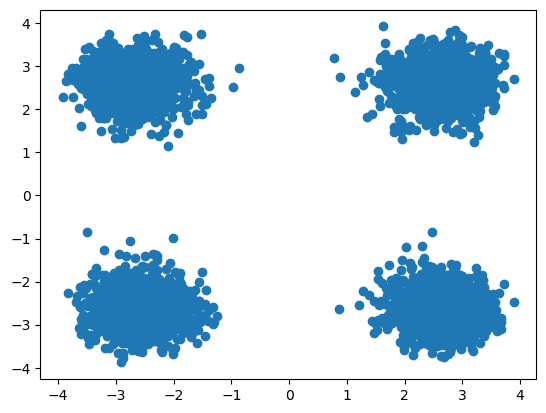

In [39]:
cfqr.show_initial_state()

In [40]:
manual_domain=[np.array([-5, -5])/time_scale_factor, np.array([5, 5])/time_scale_factor]
mapping_state_1_to_state_2_dict = {"00": ["00", "10"], "01": ["00", "10"], "10": ["01", "11"], "11": ["01", "11"]}

In [41]:
# step 5: perform simulations

simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
                        potential = coupled_fq_pot, potential_default_param = coupled_fq_default_param,            
                        initial_state = init_state_saved, manual_domain = manual_domain, \
                        phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx, \
                        percentage = 1, as_step = np.s_[::])


 initializing...
use old initial_state
as step value: slice(None, None, None), sampleSize: 5000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.001
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 1. 4. 4.] and eta: [0.01853177 0.01853177 0.01853177 0.01853177]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 240.0
from simulation.py: number of steps: 240000, dt: 0.001

 running sim...
final_statestep 239999
work_done

 analyzing output...
(1068.1297430992126,)


In [42]:
simResult["fidelity"]

[{'initial': [1258, 0, 0, 0],
  'final': [646, 0, 609, 3],
  'final_percentage': ['0.514', '0.000', '0.484', '0.002']},
 {'initial': [0, 1247, 0, 0],
  'final': [629, 1, 617, 0],
  'final_percentage': ['0.504', '0.001', '0.495', '0.000']},
 {'initial': [0, 0, 1245, 0],
  'final': [1, 642, 1, 601],
  'final_percentage': ['0.001', '0.516', '0.001', '0.483']},
 {'initial': [0, 0, 0, 1250],
  'final': [0, 649, 2, 599],
  'final_percentage': ['0.000', '0.519', '0.002', '0.479']}]

# animations

In [20]:
# # animations
# vmin, vmax = 0, 100
# frame_skip = 100
# # phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx
# particle_number = 0
# # all_state = simResult["cfqr"].sim.output.all_state['states'][particle_number:particle_number+1, :, :, :]
# all_state = simResult["cfqr"].sim.output.all_state['states']
# simResult["cfqr"].system.protocol_list = protocol_list
# time_range = (computation_protocol_parameter_dict["t"][0], computation_protocol_parameter_dict["t"][-1])

# ani,_,_ = animate_sim_flux_qubit(all_state, system = simResult["cfqr"].system ,
#                                    times = time_range, frame_skip=frame_skip, color_by_state=True,
#                                    vmin = vmin, vmax = vmax,
#                                    manual_domain = manual_domain)



In [21]:
# # from IPython.display import HTML
# from IPython import display
# video = ani.to_html5_video()
# html = display.HTML(video)
# display.display(html)

# work analysis

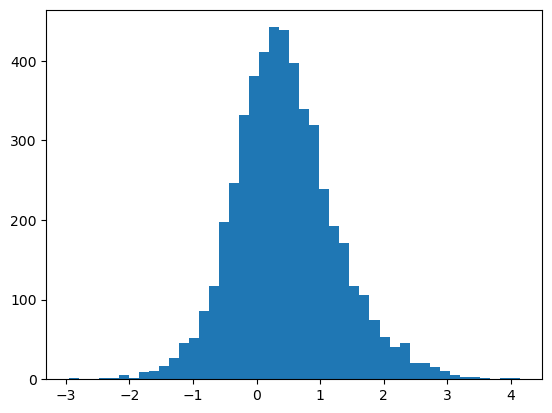

jarzyn = 0.8588940720267813, mean work = 0.45504804898922757
[40, 40, 40, 40, 40, 40]


In [43]:
# %%notify
step_time_array = np.cumsum(np.array([x["duration"] for x in protocol_list]))/params['dt']
name_array = [x["name"] for x in protocol_list]


plt.hist(simResult["work_distribution"], bins = 45)
plt.show()
mean_work = np.mean(simResult["work_distribution"])
jarzyn_term = np.mean(np.exp(-
                             simResult["work_distribution"]))
print(f'jarzyn = {jarzyn_term}, mean work = {mean_work}')
print([x["duration"] for x in protocol_list])

0.4995619033877814 7.853747883146411e-07
jarzyn = 0.8588940720267813
[40, 40, 40, 40, 40, 40]


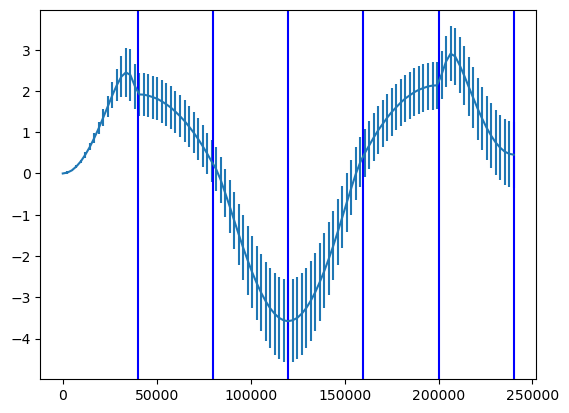

In [44]:


step_array = np.arange(simResult["work_statistic"][:,0].shape[0])
skip_step = int(len(step_array) * 0.01)
work_mean = simResult["work_statistic"][:,0]
work_std = simResult["work_statistic"][:,1]

coarse_step_array = step_array[::skip_step]
coarse_step_array = np.append(coarse_step_array, step_array[-1])
coarse_work_mean_array = work_mean[::skip_step]
coarse_work_mean_array = np.append(coarse_work_mean_array, work_mean[-1])
coarse_work_std_array = np.append(work_std[::skip_step], work_std[-1])

plt.errorbar(coarse_step_array, coarse_work_mean_array, yerr = coarse_work_std_array)

for i, t in enumerate(step_time_array):
    plt.axvline(x = t, color = 'b', label = 'axvline - full height')
    # plt.text('2017-07-02 16:30:00',0.005,'BigNews1',rotation=90,va='top')
    plt.annotate(f"{i+1}", 
            xy=(t, 4.5),  
            # xytext=(quantile_75, 2.05*1e9),
            color='red', 
            ha='center', 
            size=16)



first_half = work_mean[0: len(work_mean)//2]
second_half = work_mean[len(work_mean)//2:][::-1]
abs_error = np.abs(first_half - second_half)
# plt.plot(step_array[0:len(step_array)//2], abs_error)
print(max(abs_error), min(abs_error))
print(f'jarzyn = {jarzyn_term}')
print([x["duration"] for x in protocol_list])

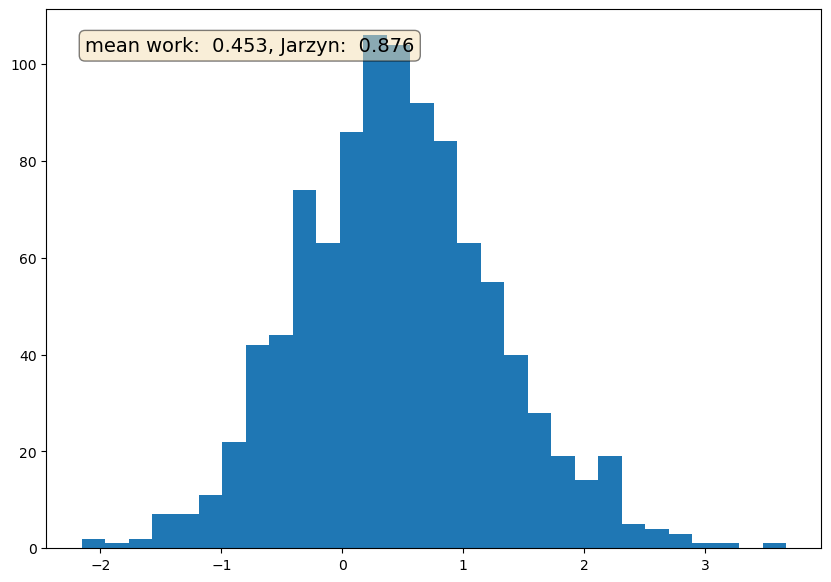

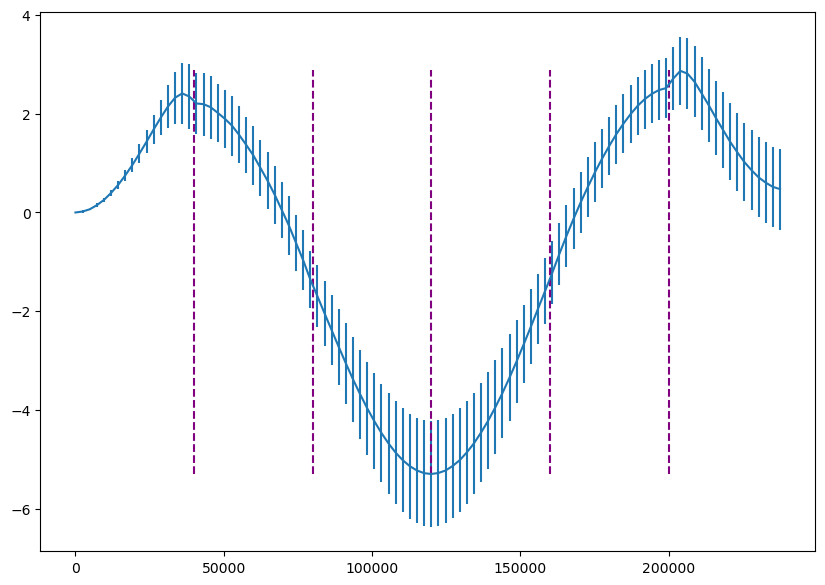

In [32]:
# 100, w_mena = 1.37, jarzyn = 0.342
# 80, w_mena = 1.37, jarzyn = 0.342
# 40, w_mena = 1.36, jarzyn = 0.34
cfq_batch_sweep.saveSimulationResult(simResult, U0_1, timeOrStep = 'step', save = True, save_final_state = False)

In [33]:
simResult['simulation_data']

{'simulation_time': (193.65312004089355,),
 'simulation_date': '2024-01-16 14:32:33.873134',
 'simulation_id': 'e18f8ac6c60bb68de0d804f730a7d57c4789b42d2283b3596a9dae56be1ac34a',
 'simulation_computer': 'mothra.local',
 'saveTime': '1705444638.795828'}

dw = 0.001, dt = 0.0002, N = 5000
LHS: number of +W, RHS = number of -W * np.exp(+W)]


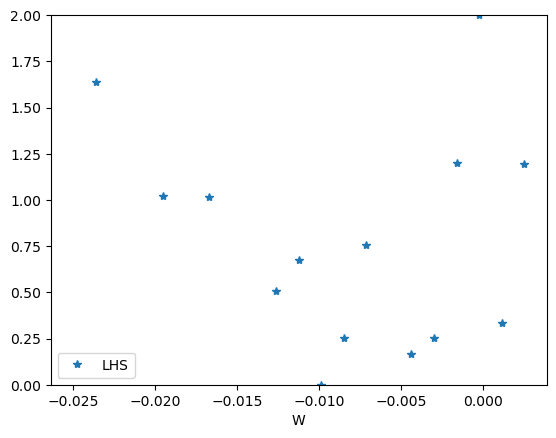

In [24]:
# crook analysis
# np.linspace(0.005, 0.2, 100)
test_w = np.linspace(-0.025, 0.0025, 21)
dw = 0.001
crook_analysis_result = []

for _w in test_w:
    array = simResult["work_distribution"]

    # The 0 index is to remove the single element array
    number_of_plus_W = len(np.where(np.logical_and(array <= _w + dw, array >= _w - dw))[0])
    number_of_minus_W = len(np.where(np.logical_and(array <= -_w + dw, array >= -_w - dw))[0])
    crook_analysis_result.append(np.array([_w, number_of_plus_W, number_of_minus_W * np.exp(_w)]))

crook_analysis_result = np.array(crook_analysis_result)    
print(f"dw = {dw}, dt = {params['dt']}, N = {params['N']}")
print("LHS: number of +W, RHS = number of -W * np.exp(+W)]")
all_w = crook_analysis_result[:, 0]
all_lhs = crook_analysis_result[:, 1]
all_rhs = crook_analysis_result[:, 2]
plt.xlabel("W")
plt.ylim([0, 2])
plt.plot(all_w, all_lhs/all_rhs, "*", label = "LHS")
# plt.plot(all_w, all_rhs, "-", label = "RHS")
plt.legend()
plt.show()
# print("p(W) = p(-W) exp(W)")
# print(f"LHS = {number_of_plus_W}, RHS = {number_of_minus_W * np.exp(test_w)}")
# print(f"mean work = {avg_W:.3f} and the std error of W = {error_W:.5f}")
# print(f'jarzyn = {jarzyn_term:.3f}, std error= {jarzyn_term_error:.5f}')
# print([x["duration"] for x in protocol_list])
# print(time_length_1, time_length_2, time_length_3, time_length_4, time_length_5, time_length_6)

In [25]:
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-2, 2, 50),density=True)
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-0.01, 0.01, 20),density=True)

In [26]:
log_P_ratio = np.log(counts / counts[::-1])

/var/folders/lg/s5mcr4vx5p76ymtpjnvb304m0000gq/T/ipykernel_8983/3448178815.py:1: RuntimeWarning: divide by zero encountered in divide
  log_P_ratio = np.log(counts / counts[::-1])
/var/folders/lg/s5mcr4vx5p76ymtpjnvb304m0000gq/T/ipykernel_8983/3448178815.py:1: RuntimeWarning: divide by zero encountered in log
  log_P_ratio = np.log(counts / counts[::-1])


Text(0, 0.5, 'log ratio')

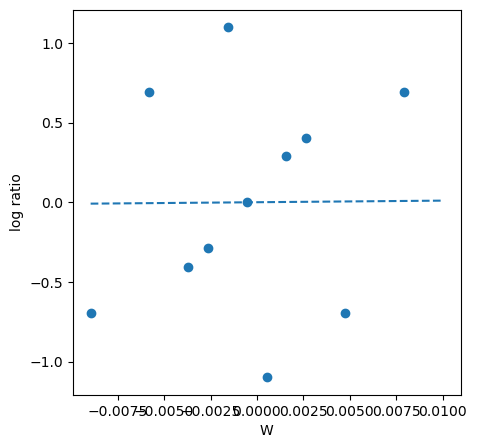

In [27]:
plt.figure(figsize=(5, 5))
plt.plot(bin_edges[1:], bin_edges[1:], "--")
plt.scatter(bin_edges[:-1], log_P_ratio)
plt.xlabel("W")
plt.ylabel("log ratio")

dw = 0.001, dt = 0.0002, N = 5000
LHS: number of +W, RHS = number of -W * np.exp(+W)]


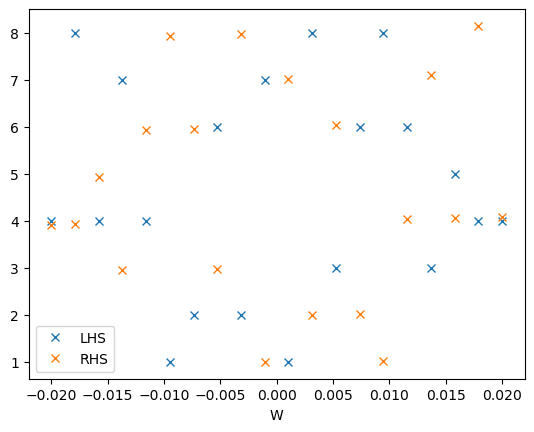

NameError: name 'avg_W' is not defined

In [23]:
# crook analysis
# np.linspace(0.005, 0.2, 100)
test_w = np.linspace(-0.02, 0.02, 20)
dw = 0.001
crook_analysis_result = []

for _w in test_w:
    array = simResult["work_distribution"]

    # The 0 index is to remove the single element array
    number_of_plus_W = len(np.where(np.logical_and(array <= _w + dw, array >= _w - dw))[0])
    number_of_minus_W = len(np.where(np.logical_and(array <= -_w + dw, array >= -_w - dw))[0])
    crook_analysis_result.append(np.array([_w, number_of_plus_W, number_of_minus_W * np.exp(_w)]))

crook_analysis_result = np.array(crook_analysis_result)    
print(f"dw = {dw}, dt = {params['dt']}, N = {params['N']}")
print("LHS: number of +W, RHS = number of -W * np.exp(+W)]")
all_w = crook_analysis_result[:, 0]
all_lhs = crook_analysis_result[:, 1]
all_rhs = crook_analysis_result[:, 2]
plt.xlabel("W")
plt.plot(all_w, all_lhs, "x", label = "LHS")
plt.plot(all_w, all_rhs, "x", label = "RHS")
plt.legend()
plt.show()
# print("p(W) = p(-W) exp(W)")
# print(f"LHS = {number_of_plus_W}, RHS = {number_of_minus_W * np.exp(test_w)}")
print(f"mean work = {avg_W:.3f} and the std error of W = {error_W:.5f}")
print(f'jarzyn = {jarzyn_term:.3f}, std error= {jarzyn_term_error:.5f}')
print([x["duration"] for x in protocol_list])
print(time_length_1, time_length_2, time_length_3, time_length_4, time_length_5, time_length_6)

# fidelity analysis

['initial\nfinal\nfinal_percentage',
 'initial\nfinal\nfinal_percentage',
 'initial\nfinal\nfinal_percentage',
 'initial\nfinal\nfinal_percentage']

In [54]:
final_percentage_matrix

array([['0.504', '0.494', '0.000', '0.002'],
       ['0.000', '0.001', '0.522', '0.560'],
       ['0.495', '0.504', '0.001', '0.002'],
       ['0.002', '0.001', '0.477', '0.437']], dtype='<U5')

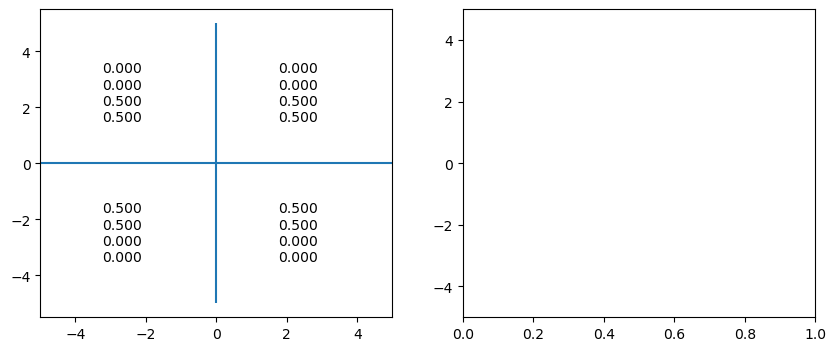

In [6]:
# final_percentage_matrix = np.array([d["final_percentage"] for d in simResult["fidelity"]]).T
# text_box_array = ["\n".join(row) for row in final_percentage_matrix]

fig, ax = plt.subplots(1, 2, figsize = [10, 4])
# plt.figure(figsize=[4, 4])
# plt.title(f"N = {item['N']}, dt = {item['dt']}, t1 = {item['protocol_list'][-1]['duration']} ")
# _ax = ax[1]
# _ax.set_xlim(-5, 5);plt.ylim(-5, 5);
# _ax.text(-3.25, -3.5, text_box_array[0]); _ax.text(-3.25, 1.5, text_box_array[1])
# _ax.text(1.75, -3.5, text_box_array[2]); _ax.text(1.75, 1.5, text_box_array[3])
# _ax.vlines(0, ymin = -5, ymax = 5); _ax.hlines(0, xmin = -5, xmax = 5)

ideal_fidelity = np.array([['0.500', '0.000', '0.500', '0.000'], ['0.500', '0.000', '0.500', '0.000'],
                          ['0.000', '0.500', '0.000', '0.500'], ['0.000', '0.500', '0.000', '0.500']]).T
text_box_array = ["\n".join(row) for row in ideal_fidelity]
# plt.figure(figsize=[4, 4])
# plt.title(f"N = {item['N']}, dt = {item['dt']}, t1 = {item['protocol_list'][-1]['duration']} ")
_ax = ax[0]
_ax.set_xlim(-5, 5);plt.ylim(-5, 5);
_ax.text(-3.25, -3.5, text_box_array[0]); _ax.text(-3.25, 1.5, text_box_array[1])
_ax.text(1.75, -3.5, text_box_array[2]); _ax.text(1.75, 1.5, text_box_array[3])
_ax.vlines(0, ymin = -5, ymax = 5); _ax.hlines(0, xmin = -5, xmax = 5)

In [34]:
import copy

In [51]:
ideal_fidelity = copy.deepcopy(final_percentage_matrix)

In [49]:
ideal_fidelity[0]["final_percentage"] = ['0.500', '0.000', '0.500', '0.000']
ideal_fidelity[1]["final_percentage"] = ['0.500', '0.000', '0.500', '0.000']
ideal_fidelity[2]["final_percentage"] = ['0.000', '0.500', '0.000', '0.500']
ideal_fidelity[3]["final_percentage"] = ['0.000', '0.500', '0.000', '0.500']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [52]:
ideal_fidelity

array([['0.504', '0.494', '0.000', '0.002'],
       ['0.000', '0.001', '0.522', '0.560'],
       ['0.495', '0.504', '0.001', '0.002'],
       ['0.002', '0.001', '0.477', '0.437']], dtype='<U5')